# Task 10: Benchmark Top ML Algorithms

## 1. Libraries and Dependencies

In [394]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## 2. Data Loader

In [288]:
def data_loader():
    df_train = pd.read_csv("loan_train.csv")
    return df_train

df_train = data_loader()

## 3. Data Exploration

In [289]:
df_train.shape

(614, 13)

We have 614 rows and 13 features.

In [290]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [291]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [292]:
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [293]:
df_train.drop(columns=["Loan_ID"], inplace=True)

There are few null values. Let's check the percentage of null values it has.

In [294]:
def get_perct_null_values(df):
    total_values = df.shape[0]
    null_counts = df.isnull().sum()
  
    null_percentages = ((null_counts / total_values) * 100).round(2)
    result_df = pd.DataFrame({'Column': null_counts.index, 'Null Count': null_counts.values, 'Null Percentage': null_percentages.values})
    print(f"There are {null_counts.sum()} null values in the dataset out of {total_values}")
    return result_df
    
get_perct_null_values(df_train)

There are 149 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,13,2.12
1,Married,3,0.49
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,32,5.21
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,22,3.58
8,Loan_Amount_Term,14,2.28
9,Credit_History,50,8.14


#### Plot missing values graph

<Axes: >

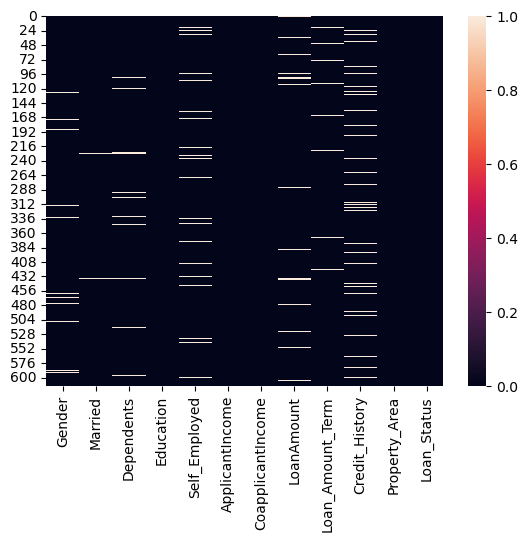

In [295]:
sns.heatmap(df_train.isnull())

We have so many null values for credit history. Let's explore.

In [296]:
df_train["Credit_History"].unique()

array([ 1.,  0., nan])

In [297]:
categorical_cols = df_train.select_dtypes(include=object).columns
numerical_cols = df_train.select_dtypes(include=[int, float]).columns

#### Plot count plot

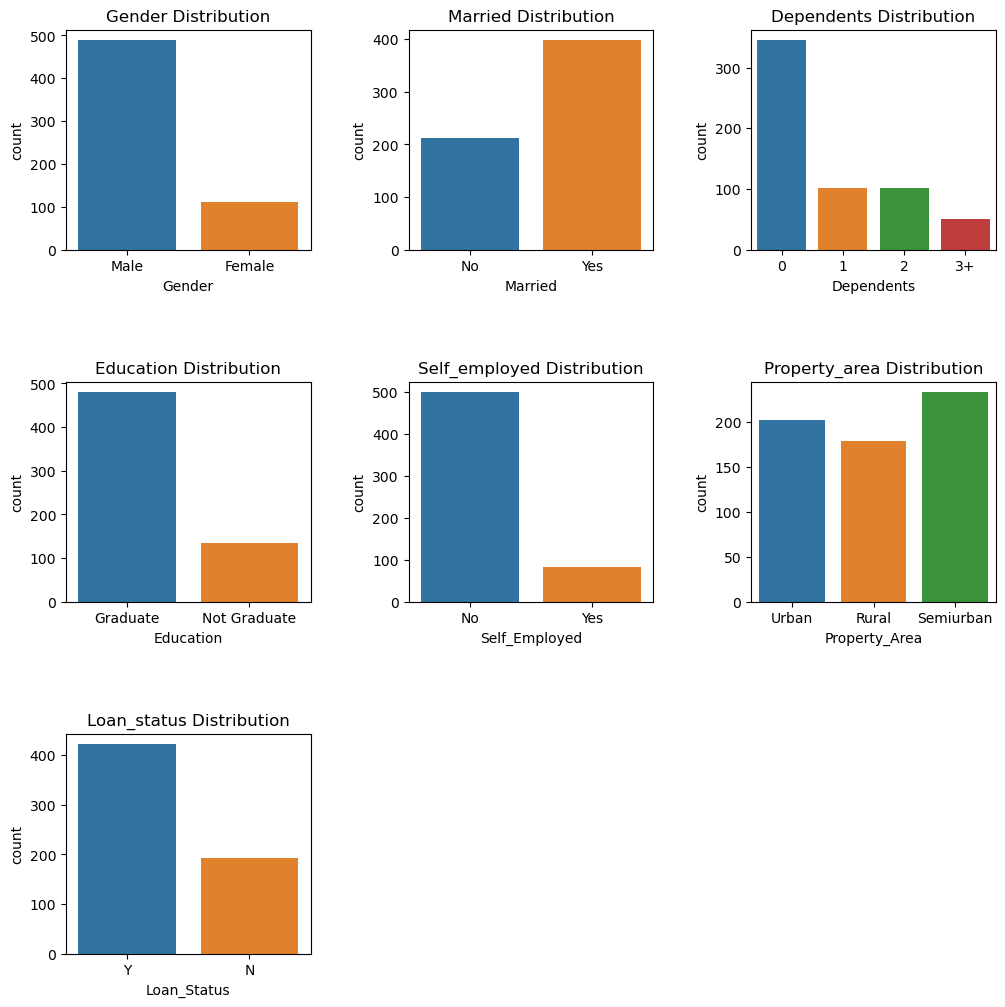

In [298]:
num_plots = len(categorical_cols)
num_cols = 3
num_rows = (num_plots // num_cols) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(df_train, x=column, ax=ax)
    ax.set_title(f"{column.capitalize()} Distribution") 
    plt.xlabel(column)
    
# Remove any empty plots
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])
    
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#### Analyze the distribution of the target feature

In [299]:
(df_train['Loan_Status'].value_counts(normalize=True) * 100).round(2)

Y    68.73
N    31.27
Name: Loan_Status, dtype: float64

## 4. Data Preprocessing

#### Convert target feature to 0's and 1's

In [300]:
df_train["Loan_Status"] = df_train["Loan_Status"].map({"Y": 1, "N": 0})

### Handle Missing data

#### Handling Credit History

There are around 50 null values in Credit_History feature. We'll fill all the null values with 0. As null values means, the person doesn't have a credit history.

In [301]:
df_train["Credit_History"] = df_train["Credit_History"].fillna(0)

In [302]:
get_perct_null_values(df_train)

There are 99 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,13,2.12
1,Married,3,0.49
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,32,5.21
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,22,3.58
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


#### Handle Gender feature

Here there are 13 null values. We can impute the most predominant value here i.e Male

In [303]:
imputer = SimpleImputer(strategy='most_frequent')
df_train['Gender'] = imputer.fit_transform(df_train[['Gender']])

In [304]:
get_perct_null_values(df_train)

There are 86 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.00
1,Married,3,0.49
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,32,5.21
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,22,3.58
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


#### Handle Self_Employed feature.

Here, there are 32 null values in self_employed.

In [305]:
df_train.Self_Employed.value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

Here, we can see that No is predominant value in the feature. We can use simple imputer to impute most_frequent value.

In [306]:
df_train["Self_Employed"] = imputer.fit_transform(df_train[["Self_Employed"]])

In [307]:
get_perct_null_values(df_train)

There are 54 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.00
1,Married,3,0.49
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,0,0.00
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,22,3.58
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


#### Handle skewness of LoanAmount feature

<Axes: >

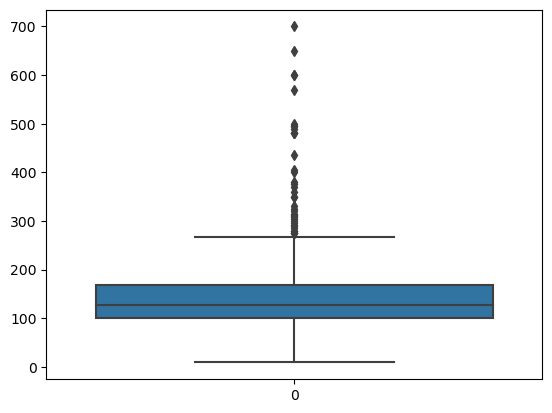

In [308]:
sns.boxplot(df_train.LoanAmount)

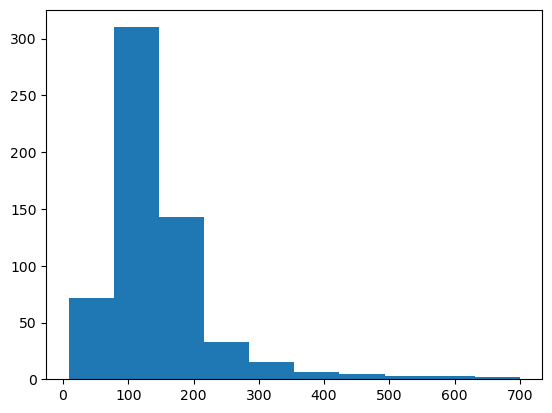

In [309]:
plt.hist(df_train.LoanAmount);

In [310]:
df_train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [311]:
df_train[df_train.LoanAmount > 300].shape

(29, 12)

In [312]:
threshold = 400
df_train['LoanAmount'] = df_train['LoanAmount'].apply(lambda x: threshold if x > threshold else x)

#### Handle null values in LoanAmount Feature

Here there are 22 null values in this feature. We'll use mean values to impute them.

In [313]:
imputer = SimpleImputer(strategy='mean')

df_train['LoanAmount'] = imputer.fit_transform(df_train[['LoanAmount']])

In [314]:
get_perct_null_values(df_train)

There are 32 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.00
1,Married,3,0.49
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,0,0.00
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,0,0.00
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


#### Handle Married feature

There are only 3 null values. We can drop them, but as our dataset is small we'll place the most frequent value.

In [315]:
imputer = SimpleImputer(strategy='most_frequent')

df_train['Married'] = imputer.fit_transform(df_train[['Married']])

In [316]:
get_perct_null_values(df_train)

There are 29 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.00
1,Married,0,0.00
2,Dependents,15,2.44
3,Education,0,0.00
4,Self_Employed,0,0.00
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,0,0.00
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


### Handle Dependents and Loan_Amount_Term features.

In [317]:
imputer = SimpleImputer(strategy='most_frequent')

df_train['Dependents'] = imputer.fit_transform(df_train[['Dependents']])

In [318]:
get_perct_null_values(df_train)

There are 14 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.00
1,Married,0,0.00
2,Dependents,0,0.00
3,Education,0,0.00
4,Self_Employed,0,0.00
5,ApplicantIncome,0,0.00
6,CoapplicantIncome,0,0.00
7,LoanAmount,0,0.00
8,Loan_Amount_Term,14,2.28
9,Credit_History,0,0.00


In [319]:
imputer = SimpleImputer(strategy='most_frequent')

df_train['Loan_Amount_Term'] = imputer.fit_transform(df_train[['Loan_Amount_Term']])

In [320]:
get_perct_null_values(df_train)

There are 0 null values in the dataset out of 614


,Column,Null Count,Null Percentage
0,Gender,0,0.0
1,Married,0,0.0
2,Dependents,0,0.0
3,Education,0,0.0
4,Self_Employed,0,0.0
5,ApplicantIncome,0,0.0
6,CoapplicantIncome,0,0.0
7,LoanAmount,0,0.0
8,Loan_Amount_Term,0,0.0
9,Credit_History,0,0.0


Now, we have 0 null values. We'll handle dataset imbalance now.

### Tranforming Data

#### Convert Married and Self Employed to binary columns

In [321]:
df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5849,0.0,143.402027,360.0,1.0,1,1,0,0,0,0,0,1
1,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,0,0,1,0,0,1,0,0
2,1,1,1,1,3000,0.0,66.000000,360.0,1.0,1,1,0,0,0,0,0,1
3,1,1,0,0,2583,2358.0,120.000000,360.0,1.0,1,1,0,0,0,0,0,1
4,1,0,1,0,6000,0.0,141.000000,360.0,1.0,1,1,0,0,0,0,0,1


In [322]:
binary_columns_with_yes_no = ["Married", "Self_Employed"]

In [323]:
df_train[binary_columns_with_yes_no] = df_train[binary_columns_with_yes_no].apply(lambda col: col.map({"Yes": 1, "No": 0}))

#### Convert gender feature into binary numerical feature

In [324]:
df_train["Gender"] = df_train["Gender"].map({"Male": 1, "Female": 0})

#### Convert Education feature into binary numerical feature

In [325]:
df_train.Education.value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [326]:
df_train["Education"] = df_train["Education"].map({"Graduate": 1, "Not Graduate": 0})

#### Handle Dependents and Property area using One hot encoding.

In [327]:
categorical_cols = df_train.select_dtypes(include=object).columns

In [328]:
categorical_cols

Index(['Dependents', 'Property_Area'], dtype='object')

In [329]:
df = pd.get_dummies(df_train, columns=categorical_cols, prefix=categorical_cols)

### Handle dataset imbalance using SMOTE

#### Divide the dataset

In [330]:
X = df.drop(columns=["Loan_Status"])
y = df["Loan_Status"]

#### Split data into train test

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9, test_size=.3)

We split the data first before using SMOTE to avoid data leakage.

#### Scale data

In [336]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Apply SMOTE

In [341]:
smote = SMOTE(sampling_strategy='auto', random_state=9)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

## 5. Model Building

### A) Logistic Regression

In [398]:
def log_regression(X_resampled, y_resampled, X_test_scaled, y_test):
    log_reg = LogisticRegression(random_state=9)
    
    param_grid = {
        'penalty': ['l1', 'l2'],             
        'C': [0.001, 0.01, 0.1, 1, 10],         
        'solver': ['liblinear']
    }
    
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring='accuracy',             
        cv=5,                               
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_resampled, y_resampled)
    
    print("Best params for Logistic Regression are: ", grid_search.best_params_)
    
    best_model = grid_search.best_estimator_
    
    print("The accurcy score for Logistic regreesion is: ", accuracy_score(y_test, best_model.predict(X_test_scaled)))
    

In [399]:
log_regression(X_resampled, y_resampled, X_test_scaled, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Logistic Regression are:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
The accurcy score for Logistic regreesion is:  0.7567567567567568


## B) Decision Tree

In [396]:
def decission_tree(X_resampled, y_resampled, X_test_scaled, y_test):
    
    decision_tree = DecisionTreeClassifier(random_state=9)
    
    param_grid = {
        'criterion': ['gini', 'entropy'],    
        'max_depth': [None, 5, 10, 15, 20],  
        'min_samples_split': [2, 5, 10, 20], 
        'min_samples_leaf': [1, 2, 4, 8]     
    }
    
    grid_search = GridSearchCV(
        estimator=decision_tree,
        param_grid=param_grid,
        scoring='accuracy',             
        cv=5,                            
        verbose=1,                            
        n_jobs=-1                            
    )
    
    grid_search.fit(X_resampled, y_resampled)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)

    print("\nClassification Report on Test Data:")
    print(classification_report(y_test, y_pred))
    
    print(accuracy_score(y_test, y_pred))


In [397]:
decission_tree(X_resampled, y_resampled, X_test_scaled, y_test)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best Cross-Validation Score: 0.7169

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        65
           1       0.71      0.83      0.77       120

    accuracy                           0.68       185
   macro avg       0.63      0.61      0.61       185
weighted avg       0.66      0.68      0.66       185

0.6756756756756757


## C) SVM

In [407]:
def svm_classifer(X_resampled, y_resampled, X_test_scaled, y_test):
    
    svm_classifier = SVC()
    

    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],            # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel function
        'degree': [2, 3, 4, 5],                        # Degree of the polynomial kernel (for 'poly' kernel)
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Kernel coefficient
    }

    
    grid_search = GridSearchCV(
        estimator=svm_classifier,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,                        
        verbose=1,
        n_jobs=-1                      
    )
    
    grid_search.fit(X_resampled, y_resampled)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred)
    
    print(f"Best Hyperparameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report_str)

In [408]:
svm_classifer(X_resampled, y_resampled, X_test_scaled, y_test)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Hyperparameters: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.6270

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.32      0.38        65
           1       0.68      0.79      0.73       120

    accuracy                           0.63       185
   macro avg       0.57      0.56      0.56       185
weighted avg       0.60      0.63      0.61       185

